### Lab 6

#### Desarrollado por:
- Alejandro Gómez
- Roberto Vallecillos
- Paola de León

In [1]:
# Librerias
import pandas as pd
import numpy as np
from sklearn import *
from scipy import *
import matplotlib.pyplot as plt
import seaborn as sns

### Task 1.1 Clasificación League of Legends

In [2]:
# Lectura de csv
LoLData = pd.read_csv('high_diamond_ranked_10min.csv')
LoLData.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [3]:
# Eliminar duplicados
LoLData.drop_duplicates(inplace=True)
# Eliminar valores nulos
LoLData.dropna(inplace=True)

#### Análisis exploratorio

0    0.500962
1    0.499038
Name: blueWins, dtype: float64


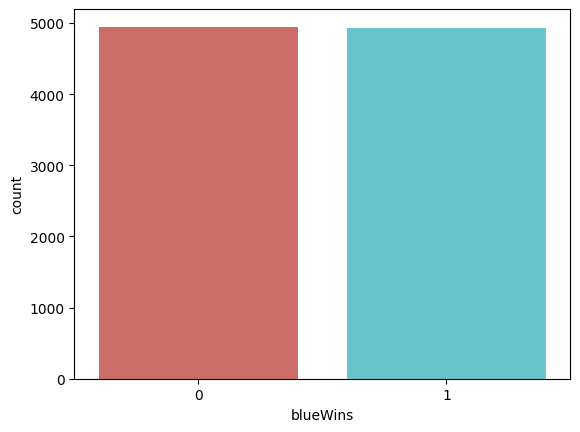

In [4]:
# Análisis exploratorio

sns.countplot(x='blueWins', data=LoLData, palette='hls')

porcentajeBlue = LoLData['blueWins'].value_counts(normalize=True)

print(porcentajeBlue)

<AxesSubplot:xlabel='blueWins', ylabel='count'>

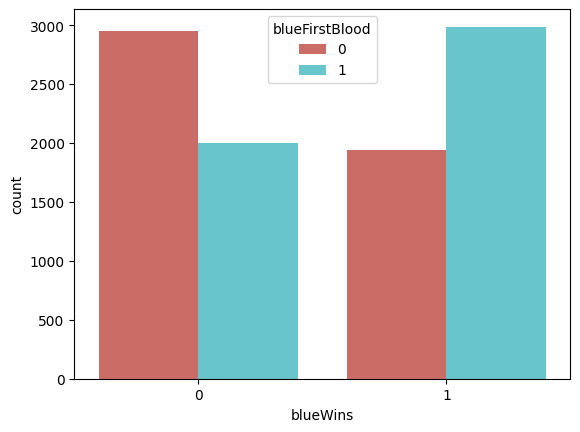

In [5]:
# Gráfico exploratorio
sns.countplot(x='blueWins', hue='blueFirstBlood', data=LoLData, palette='hls')

<AxesSubplot:>

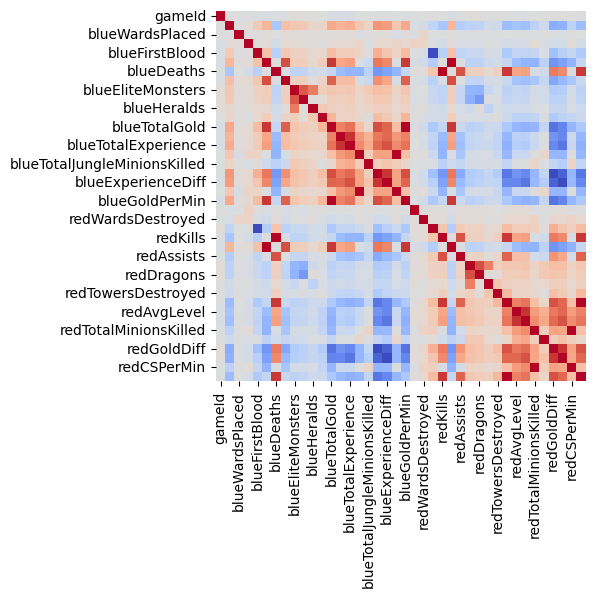

In [6]:
sns.heatmap(data=LoLData.corr(), cbar=False,  square=True, fmt='.2f', annot_kws={'size': 15}, cmap='coolwarm')

#### Implementación

In [7]:
class Node:
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gini=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gini = gini
        self.value = value

In [8]:
from collections import Counter


class DecisionTree:
    def __init__(self, min_samples_split=5, max_depth=10):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        
    @staticmethod
    def entropia(s):
        # Conversión a enteros
        counts = np.bincount(np.array(s, dtype=np.int64))
        # Probabildades de la clase
        percentages = counts / len(s)

        # Calculo de entropía
        entropy = 0
        for pct in percentages:
            if pct > 0:
                entropy += pct * np.log2(pct)
        return -entropy
    
    def info_gini(self, parent, left, right):
        num_left = len(left) / len(parent)
        num_right = len(right) / len(parent)
        
        # Formula para poder encontrar lo que se gana por la entropía, o valor GINI
        gini = self.entropia(parent) - (num_left * self.entropia(left) + num_right * self.entropia(right))
        return gini
    
    def split(self, X, y):
        best_split = {}
        best_info_gini = -1
        n_cols = X.shape[1]
        
        # Revisa todos las columnas de la base datos.
        for f_idx in range(n_cols):
            X_curr = X[:, f_idx]
            # Revisa los valores unicos de la columna
            for threshold in np.unique(X_curr):
                # Construcción de la división. Los valores de la izuquierda son menor o igual que un punto Los valores de la derecha son mayor que un punti
                df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
                df_left = np.array([row for row in df if row[f_idx] <= threshold])
                df_right = np.array([row for row in df if row[f_idx] > threshold])

                # Calculo si existo información en ambos lados
                if len(df_left) > 0 and len(df_right) > 0:
                    # Valor de los subconjuntos.
                    y = df[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]

                    # Revisa la información, y basadao en cual es el mejor ganancia, salva esa información. Vaor de GINI
                    gini = self.info_gini(y, y_left, y_right)
                    if gini > best_info_gini:
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'df_left': df_left,
                            'df_right': df_right,
                            'gini': gini
                        }
                        best_info_gini = gini
        return best_split
    
    def build_tree(self, X, y, depth=0):
        n_rows = X.shape[0]
        
        # Revisa si el nodo es nodo final o se puede hacer una división
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            # Mira el split ideal
            best = self.split(X, y)
            #  Valor de Gini
            if best['gini'] > 0:
                # Creación de árbol de izquierda
                left = self.build_tree(
                    X=best['df_left'][:, :-1], 
                    y=best['df_left'][:, -1], 
                    depth=depth + 1
                )
                right = self.build_tree(
                    X=best['df_right'][:, :-1], 
                    y=best['df_right'][:, -1], 
                    depth=depth + 1
                )
                # Creación de árbol de izquierda
                return Node(
                    feature=best['feature_index'], 
                    threshold=best['threshold'], 
                    data_left=left, 
                    data_right=right, 
                    gini=best['gini']
                )
        # Valor objetivo más comun
        return Node(
            value=Counter(y).most_common(1)[0][0]
        )
    
    def fit(self, X, y):
        # Función de los datos para poder hacer el arbol y ahcer un fit.
        self.root = self.build_tree(X, y)
        
    def travel(self, x, tree):

        # Viaje del nodo principial. Recursión para la izquierda y derecha.
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]
        
        if feature_value <= tree.threshold:
            return self.travel(x=x, tree=tree.data_left)
        
        if feature_value > tree.threshold:
            return self.travel(x=x, tree=tree.data_right)
        
    def predict(self, X):
        # Función para las predicciónes
        return [self.travel(x, self.root) for x in X]


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
X = LoLData[["blueWardsPlaced","blueWardsDestroyed","blueFirstBlood","blueKills","blueDeaths","blueAssists","blueEliteMonsters","blueDragons"]]
y = LoLData['blueWins']
normalizador = StandardScaler()
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X, y, test_size=.5, random_state=42)
X_train = normalizador.fit_transform(X_train)
X_valid = normalizador.fit_transform(X_valid)
X_test = normalizador.fit_transform(X_test)
y_train= y_train.values
y_valid = y_valid.values
y_test= y_test.values


In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score
from typing import Iterable, Any
from itertools import product
# Función para hacer Grid Search
def grid_parameters(parameters: dict[str, Iterable[Any]]) -> Iterable[dict[str, Any]]:
    for params in product(*parameters.values()):
        yield dict(zip(parameters.keys(), params))

bestacc = 0
params = 0
preds = 0
param_grid = {'min_samples_split':[2,3,4,5], 'max_depth':[2,3,4,5]}
for x in grid_parameters(param_grid):
    print(x)
    model = DecisionTree(**x)
    model.fit(X_train, y_train)
    #Mira cual es el accuray más alto, y devuelve esos datos al final
    print("Accuracy:", accuracy_score(model.predict(X_valid), y_valid))
    if accuracy_score(model.predict(X_valid), y_valid) > bestacc:
        bestacc = accuracy_score(model.predict(X_valid), y_valid)
        params = x
        
print('Hiperparámetros: ',params)

model = DecisionTree(**params)
model.fit(X_train, y_train)
preds = model.predict(X_test)
accuracy_score(preds, y_test)

{'min_samples_split': 2, 'max_depth': 2}
Accuracy: 0.6823243571573193
{'min_samples_split': 2, 'max_depth': 3}
Accuracy: 0.6934602146183438
{'min_samples_split': 2, 'max_depth': 4}
Accuracy: 0.6985219680097186
{'min_samples_split': 2, 'max_depth': 5}
Accuracy: 0.7023689005871634
{'min_samples_split': 3, 'max_depth': 2}
Accuracy: 0.6823243571573193
{'min_samples_split': 3, 'max_depth': 3}
Accuracy: 0.6934602146183438
{'min_samples_split': 3, 'max_depth': 4}
Accuracy: 0.6985219680097186
{'min_samples_split': 3, 'max_depth': 5}
Accuracy: 0.7023689005871634
{'min_samples_split': 4, 'max_depth': 2}
Accuracy: 0.6823243571573193
{'min_samples_split': 4, 'max_depth': 3}
Accuracy: 0.6934602146183438
{'min_samples_split': 4, 'max_depth': 4}
Accuracy: 0.6985219680097186
{'min_samples_split': 4, 'max_depth': 5}
Accuracy: 0.7023689005871634
{'min_samples_split': 5, 'max_depth': 2}
Accuracy: 0.6823243571573193
{'min_samples_split': 5, 'max_depth': 3}
Accuracy: 0.6934602146183438
{'min_samples_split'

0.7091093117408906

#### Proceso realizado con librerías

In [11]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

copyLol = LoLData.copy()
# Variables independientes
X = LoLData[["blueWardsPlaced","blueWardsDestroyed","blueFirstBlood","blueKills","blueDeaths","blueAssists","blueEliteMonsters","blueDragons"]]
# Variable objetivo
y = LoLData['blueWins']

# Dividir el conjunto de datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=0)

# Crear el objeto de clasificación

Tree = DecisionTreeClassifier()

# Entrenar el modelo

Tree.fit(X_train, y_train)

# Predecir el conjunto de datos de prueba

y_pred = Tree.predict(X_test)

# Metricas
accuracy = metrics.accuracy_score(y_test, y_pred)
Precision = metrics.precision_score(y_test, y_pred)

# Accuracy y Precision
print("Accuracy:", accuracy)
print("Precision:", Precision)

Accuracy: 0.617914979757085
Precision: 0.6107784431137725


In [12]:
# Representatión del arbol
representacion = tree.export_text(Tree)
print(representacion)

|--- feature_4 <= 6.50
|   |--- feature_3 <= 5.50
|   |   |--- feature_3 <= 3.50
|   |   |   |--- feature_7 <= 0.50
|   |   |   |   |--- feature_4 <= 3.50
|   |   |   |   |   |--- feature_4 <= 1.50
|   |   |   |   |   |   |--- feature_5 <= 2.50
|   |   |   |   |   |   |   |--- feature_5 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_1 <= 2.00
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_1 >  2.00
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- feature_5 >  0.50
|   |   |   |   |   |   |   |   |--- feature_2 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_1 <= 3.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- feature_1 >  3.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_2 >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_5 >  2.50
|   |   | 

# Taks 1.2

In [ ]:
FIFAData = pd.read_csv('FIFA/CompleteDataset.csv')
# Eliminar duplicados
FIFAData.drop_duplicates(inplace=True)
# Eliminar valores nulos
FIFAData.dropna(inplace=True)

### Análisis exploratorio

#### Revisar estructura de datos

In [45]:
FIFAData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15315 entries, 0 to 17980
Data columns (total 75 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           15315 non-null  int64  
 1   Name                 15315 non-null  object 
 2   Age                  15315 non-null  int64  
 3   Photo                15315 non-null  object 
 4   Nationality          15315 non-null  object 
 5   Flag                 15315 non-null  object 
 6   Overall              15315 non-null  int64  
 7   Potential            15315 non-null  int64  
 8   Club                 15315 non-null  object 
 9   Club Logo            15315 non-null  object 
 10  Value                15315 non-null  object 
 11  Wage                 15315 non-null  object 
 12  Special              15315 non-null  int64  
 13  Acceleration         15315 non-null  object 
 14  Aggression           15315 non-null  object 
 15  Agility              15315 non-null 

In [44]:
FIFAData.describe()

,Unnamed: 0,Age,Overall,Potential,Special,CAM,CB,CDM,CF,CM,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
count,15315.000000,15315.000000,15315.000000,15315.000000,15315.000000,15315.000000,15315.000000,15315.000000,15315.000000,15315.000000,...,15315.000000,15315.000000,15315.000000,15315.000000,15315.000000,15315.000000,15315.000000,15315.000000,15315.000000,15315.000000
mean,8878.179236,25.007117,66.406334,71.368071,1662.272935,59.217630,55.528501,56.841659,58.990924,58.477310,...,56.949265,55.528501,58.477310,56.841659,58.990924,60.018413,58.163239,59.321450,57.667777,58.163239
std,5145.767533,4.493405,6.886277,6.032389,197.626134,9.870844,12.204844,10.315181,9.915345,8.880679,...,9.798497,12.204844,8.880679,10.315181,9.915345,9.344469,9.166455,9.971523,9.148063,9.166455
min,0.000000,16.000000,46.000000,46.000000,1025.000000,27.000000,25.000000,26.000000,27.000000,30.000000,...,30.000000,25.000000,30.000000,26.000000,27.000000,28.000000,31.000000,26.000000,31.000000,31.000000
25%,4418.000000,21.000000,62.000000,67.000000,1519.000000,53.000000,45.000000,49.000000,53.000000,53.000000,...,50.000000,45.000000,53.000000,49.000000,53.000000,54.000000,52.000000,53.000000,51.000000,52.000000
50%,8840.000000,25.000000,66.000000,71.000000,1667.000000,60.000000,57.000000,58.000000,60.000000,59.000000,...,58.000000,57.000000,59.000000,58.000000,60.000000,61.000000,59.000000,60.000000,58.000000,59.000000
75%,13315.500000,28.000000,71.000000,75.000000,1803.000000,66.000000,65.000000,65.000000,66.000000,65.000000,...,64.000000,65.000000,65.000000,65.000000,66.000000,67.000000,65.000000,66.000000,64.000000,65.000000
max,17980.000000,41.000000,94.000000,94.000000,2291.000000,92.000000,87.000000,85.000000,92.000000,87.000000,...,84.000000,87.000000,87.000000,85.000000,92.000000,90.000000,92.000000,91.000000,84.000000,92.000000


#### Análisis de variables categóricas relevantes

In [ ]:
# Drop de columnas irrelevantes
FIFAData.drop(['Photo', 'Flag', 'Club Logo', ])

1      [Overall, Unnamed: 0]
7             [CAM, Special]
8              [CF, Special]
9              [CM, Special]
10            [LAM, Special]
               ...          
317                 [RM, RW]
318                 [RM, ST]
330                 [RS, RW]
331                 [RS, ST]
348                 [RW, ST]
Length: 170, dtype: object


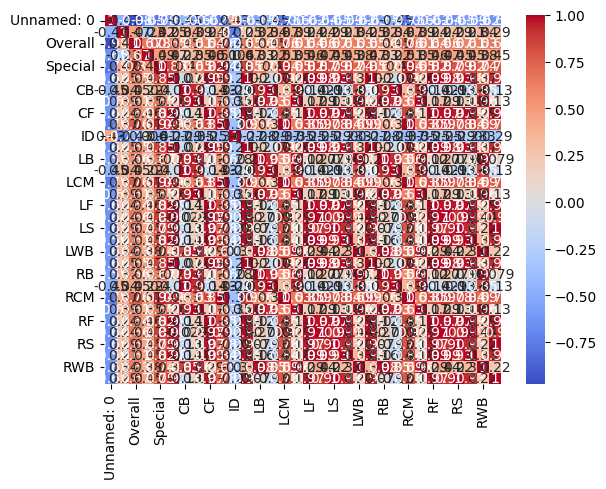

In [52]:
# Calcular matriz de correlación
corr_matrix = FIFAData.corr()

# Crear una matriz de calor de la correlación
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Seleccionar variables con alta correlación (mayor a 0.8)
high_corr_vars = corr_matrix[abs(corr_matrix) > 0.8].stack().reset_index().query('level_0 != level_1')
high_corr_vars = high_corr_vars[['level_0', 'level_1']].apply(sorted, axis=1).drop_duplicates()
print(high_corr_vars)

In [34]:
var = ["Acceleration","Aggression","Agility","Balance","Ball control","Composure","Crossing","Curve","Dribbling","Finishing","Free kick accuracy","GK diving","GK handling","GK kicking","GK positioning","GK reflexes","Heading accuracy"]
for x in var:
    FIFAData= FIFAData[pd.to_numeric(FIFAData[x], errors='coerce').notnull()]
    
FIFAData[pd.to_numeric(FIFAData['Potential'], errors='coerce').notnull()]

/var/folders/0g/6n9p7vxs5c1ccxc_tp3slgy40000gn/T/ipykernel_52730/567169664.py:1: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  FIFAData = pd.read_csv('FIFA/CompleteDataset.csv')


,Unnamed: 0,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
5,5,R. Lewandowski,28,https://cdn.sofifa.org/48/18/players/188545.png,Poland,https://cdn.sofifa.org/flags/37.png,91,91,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,...,58.0,57.0,78.0,62.0,87.0,82.0,88.0,84.0,61.0,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17974,17974,J. Keeble,18,https://cdn.sofifa.org/48/18/players/240404.png,England,https://cdn.sofifa.org/flags/14.png,46,56,Grimsby Town,https://cdn.sofifa.org/24/18/teams/92.png,...,46.0,45.0,34.0,41.0,33.0,35.0,33.0,34.0,44.0,33.0
17975,17975,T. Käßemodel,28,https://cdn.sofifa.org/48/18/players/235352.png,Germany,https://cdn.sofifa.org/flags/21.png,46,46,FC Erzgebirge Aue,https://cdn.sofifa.org/24/18/teams/506.png,...,37.0,38.0,45.0,42.0,42.0,42.0,41.0,41.0,38.0,41.0
17978,17978,J. Young,17,https://cdn.sofifa.org/48/18/players/231381.png,Scotland,https://cdn.sofifa.org/flags/42.png,46,61,Swindon Town,https://cdn.sofifa.org/24/18/teams/1934.png,...,31.0,28.0,38.0,29.0,45.0,42.0,45.0,44.0,32.0,45.0
17979,17979,J. Lundstram,18,https://cdn.sofifa.org/48/18/players/238813.png,England,https://cdn.sofifa.org/flags/14.png,46,64,Crewe Alexandra,https://cdn.sofifa.org/24/18/teams/121.png,...,47.0,46.0,45.0,47.0,43.0,45.0,41.0,44.0,46.0,41.0


70    0.068299
72    0.068168
71    0.067124
69    0.064904
73    0.061182
68    0.060986
67    0.058701
74    0.058439
75    0.050212
66    0.049951
76    0.043487
65    0.041071
77    0.036696
64    0.032452
78    0.031081
63    0.026967
79    0.025988
80    0.021286
62    0.018544
82    0.016585
81    0.016128
61    0.012929
83    0.011035
84    0.008880
60    0.008097
85    0.007574
59    0.005877
86    0.005681
58    0.005028
87    0.003069
57    0.002612
88    0.002481
56    0.001502
55    0.001306
89    0.001241
54    0.001110
90    0.000979
91    0.000522
92    0.000457
52    0.000392
53    0.000261
94    0.000196
93    0.000131
49    0.000131
51    0.000065
50    0.000065
48    0.000065
46    0.000065
Name: Potential, dtype: float64


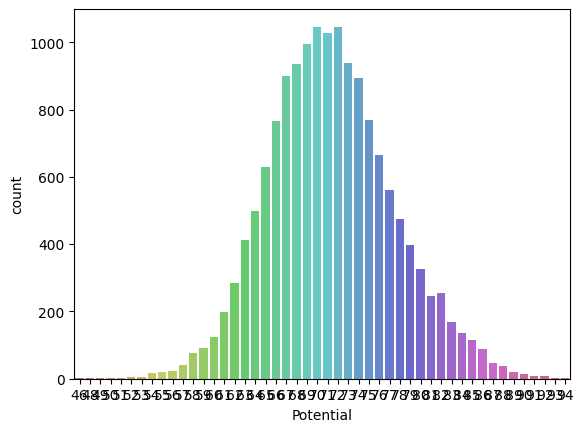

In [14]:
sns.countplot(x='Potential', data=FIFAData, palette='hls')

porcentajeBlue = FIFAData['Potential'].value_counts(normalize=True)

print(porcentajeBlue)

<AxesSubplot:>

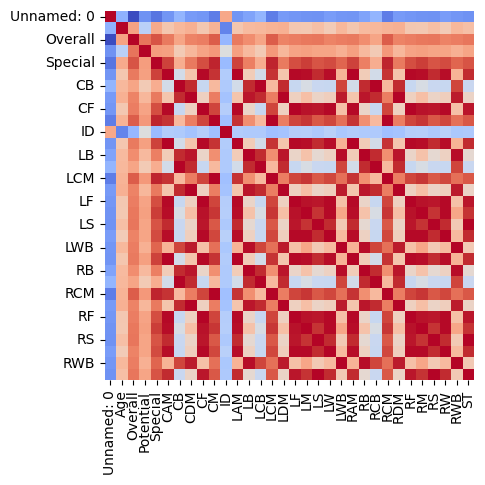

In [38]:
sns.heatmap(data=FIFAData.corr(), cbar=False,  square=True, fmt='.2f', annot_kws={'size': 50}, cmap='coolwarm')

In [16]:
# División de datos
X = FIFAData[var]
y = FIFAData['Potential']
X_train, X_temp, y_train, y_temp = model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X, y, test_size=0.5, random_state=0)

#### Verificación de importancia de features

In [17]:
# Features 
print('Las features elegidas son:')
for i in X.columns:
    print('- ' + i)

print('\n Estas consideramos que son las más significativas, pues tras un análisis de correlación y de una investigación general del tema, consideramos que son las más relevantes a utilizar en el modelo.')

Las features elegidas son:
- Acceleration
- Aggression
- Agility
- Balance
- Ball control
- Composure
- Crossing
- Curve
- Dribbling
- Finishing
- Free kick accuracy
- GK diving
- GK handling
- GK kicking
- GK positioning
- GK reflexes
- Heading accuracy

 Estas consideramos que son las más significativas, pues tras un análisis de correlación y de una investigación general del tema, consideramos que son las más relevantes a utilizar en el modelo.


#### Tunning de hiperparámetros

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score


bestr2 = 0
params = 0
preds = 0
param_grid = {'min_samples_split':[2,3,4,5], 'max_depth':[2,3,4,5]}

for x in grid_parameters(param_grid):
    print(x)
    model = DecisionTreeRegressor(**x)
    model.fit(X_train, y_train)
    # Mira cual es el rmse más alto, y devuelve esos datos al final
    y_pred = model.predict(X_valid)
    r2 = r2_score(y_valid, y_pred)
    print("R Cuadrado:", r2)
    if r2 > bestr2:
        bestr2 = r2
        params = x
        
print('\nHiperparámetros utilizados: ', params)
print('Se obtuvo un R Cuadrado de: ', bestr2)

{'min_samples_split': 2, 'max_depth': 2}
R Cuadrado: 0.31816810804074613
{'min_samples_split': 2, 'max_depth': 3}
R Cuadrado: 0.3713504751628416
{'min_samples_split': 2, 'max_depth': 4}
R Cuadrado: 0.4044249314763121
{'min_samples_split': 2, 'max_depth': 5}
R Cuadrado: 0.4375263386989454
{'min_samples_split': 3, 'max_depth': 2}
R Cuadrado: 0.31816810804074613
{'min_samples_split': 3, 'max_depth': 3}
R Cuadrado: 0.3713504751628416
{'min_samples_split': 3, 'max_depth': 4}
R Cuadrado: 0.4044249314763121
{'min_samples_split': 3, 'max_depth': 5}
R Cuadrado: 0.4375263386989454
{'min_samples_split': 4, 'max_depth': 2}
R Cuadrado: 0.31816810804074613
{'min_samples_split': 4, 'max_depth': 3}
R Cuadrado: 0.3713504751628416
{'min_samples_split': 4, 'max_depth': 4}
R Cuadrado: 0.4044249314763121
{'min_samples_split': 4, 'max_depth': 5}
R Cuadrado: 0.4375263386989454
{'min_samples_split': 5, 'max_depth': 2}
R Cuadrado: 0.31816810804074613
{'min_samples_split': 5, 'max_depth': 3}
R Cuadrado: 0.37135

In [32]:
importances = model.feature_importances_ # Ver cuales son las features más importantes en el modelo

# Data Frame con importancia de features en orden descendente
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

print(feature_importances)

               Feature  Importance
4         Ball control    0.799787
16    Heading accuracy    0.123536
10  Free kick accuracy    0.026509
9            Finishing    0.019650
1           Aggression    0.014475
5            Composure    0.008432
8            Dribbling    0.004573
0         Acceleration    0.003037
7                Curve    0.000000
6             Crossing    0.000000
3              Balance    0.000000
2              Agility    0.000000
11           GK diving    0.000000
12         GK handling    0.000000
13          GK kicking    0.000000
14      GK positioning    0.000000
15         GK reflexes    0.000000


In [ ]:
y_pred = model.predict(X_valid)

In [ ]:
# Desepeño
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))


Desempeño